# Environmental Science & Circular Economy Assistant

## Project Overview

This project fine-tunes a Large Language Model (LLM) to create a domain-specific assistant focused on **environmental science, sustainability, and circular economy practices**. The assistant provides accurate, scientific answers to questions about environmental topics and upcycling, while appropriately handling out-of-domain queries.

## Purpose

The chatbot serves as an educational and practical tool that:
- **Answers questions** about environmental science, climate change, sustainability, and ecological systems
- **Provides upcycling guidance** with practical tips for repurposing common waste materials
- **Politely refuses** questions outside its domain expertise, maintaining focus on environmental topics
- **Educates users** about circular economy principles and sustainable practices

## Domain Justification

**Why Environmental Science & Circular Economy?**

1. **Critical Global Challenge**: Climate change and environmental degradation are among the most pressing issues of our time, requiring accessible educational tools
2. **Practical Impact**: Upcycling and circular economy practices offer immediate, actionable solutions that individuals can implement
3. **Knowledge Gap**: Many people lack accessible, accurate information about environmental science and sustainable practices
4. **Educational Value**: This assistant bridges the gap between scientific knowledge and practical application, making complex environmental concepts accessible

## Model Choice: TinyLlama

**Why TinyLlama/TinyLlama-1.1B-Chat-v1.0?**

- **Colab-Compatible**: At 1.1B parameters, it fits comfortably within Google Colab's free GPU memory limits (T4 GPU ~15GB)
- **Chat-Optimized**: Pre-trained on chat format, making it ideal for conversational Q&A tasks
- **Efficient Fine-tuning**: Small size allows for faster training and experimentation with hyperparameters
- **Modern Architecture**: Based on LLaMA architecture, providing good performance despite smaller size
- **Parameter-Efficient**: Works well with LoRA (Low-Rank Adaptation) for efficient fine-tuning on limited hardware

---

## Project Structure

This notebook follows a complete LLM fine-tuning pipeline:
1. **Data Collection & Preprocessing** - Loading and cleaning domain-specific datasets
2. **Data Augmentation** - Adding upcycling examples and refusal handling
3. **Model Fine-tuning** - Using LoRA for parameter-efficient training
4. **Evaluation** - Quantitative metrics and qualitative testing
5. **Deployment** - Gradio UI for user interaction

## 1. Data Collection & Loading

### Dataset Sources

This project combines multiple data sources to create a comprehensive training dataset:

#### Primary Dataset: GeoGPT Environmental Q&A
- **Source**: GeoGPT dataset containing environmental science question-answer pairs from academic papers
- **Format**: CSV file with columns: `question`, `answer`, `title`, `authors`, `journal`, etc.
- **Size**: ~41,432 total samples (we sample 3,000 for training efficiency)
- **Why chosen**:
  - High-quality, scientifically accurate answers from peer-reviewed sources
  - Covers diverse environmental topics (climate, water quality, biodiversity, etc.)
  - Provides domain-specific knowledge base for the assistant

#### Augmentation Dataset: Manual Upcycling Q&A
- **Source**: Manually curated examples (30 samples)
- **Purpose**: Adds practical upcycling knowledge not typically found in academic papers
- **Why needed**:
  - Bridges gap between scientific knowledge and practical application
  - Provides actionable advice for circular economy practices
  - Enhances model's ability to answer "how-to" questions about waste reduction

#### Refusal Training Data: Out-of-Domain Examples
- **Source**: Manually created examples (120 samples)
- **Purpose**: Teaches the model to politely refuse non-environmental questions
- **Why critical**:
  - Maintains domain focus and prevents hallucination
  - Improves user experience by providing clear boundaries
  - Demonstrates responsible AI behavior

In [4]:
# Install required libraries
!pip -q install datasets pandas scikit-learn

# Import libraries
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive


In [5]:
# Mount Google Drive
drive.mount('/content/drive')

# Path to your GeoGPT CSV in Google Drive
file_path = "/content/drive/MyDrive/geogpt-qa.csv"

# Load dataset into pandas DataFrame
geo_df = pd.read_csv(file_path)

# Basic dataset information
print("Dataset loaded successfully")
print("\nDataset shape:", geo_df.shape)

# Show column names
print("\nColumns in dataset:")
print(list(geo_df.columns))

# Check missing values
print("\nMissing values per column:")
print(geo_df.isnull().sum())

# Data Validation: Check required columns exist
print("\n" + "=" * 60)
print("DATA VALIDATION")
print("=" * 60)
required_columns = ['question', 'answer']
missing_columns = [col for col in required_columns if col not in geo_df.columns]

if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}. Available columns: {list(geo_df.columns)}")
else:
    print(" Required columns ('question', 'answer') found")

# Validate data quality
if len(geo_df) == 0:
    raise ValueError("Dataset is empty!")
print(f" Dataset contains {len(geo_df)} rows")

if geo_df['question'].isna().all() or geo_df['answer'].isna().all():
    raise ValueError("Critical columns ('question' or 'answer') are completely empty!")
print(" Required columns contain data")

print("=" * 60)

# Preview first rows
geo_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully

Dataset shape: (41432, 10)

Columns in dataset:
['index', 'question', 'answer', 'title', 'authors', 'doi', 'journal', 'volume', 'pages', 'license']

Missing values per column:
index           0
question        0
answer          0
title           0
authors        28
doi         32746
journal         0
volume          0
pages        8686
license         0
dtype: int64

DATA VALIDATION
 Required columns ('question', 'answer') found
 Dataset contains 41432 rows
 Required columns contain data


,index,question,answer,title,authors,doi,journal,volume,pages,license
0,0,What are the key factors affecting air quality...,The key factors affecting air quality in Kalim...,Spatial effects on air quality due to the capi...,D.M. Nihayah;F.M. Sundoro;L Masluhah,doi.org/10.1088/1755-1315/1438/1/012052,IOP Conference Series: Earth and Environmental...,Volume 1438,NaN,CC-BY
1,1,How does the spatial dependence of air quality...,The spatial dependence of air quality in Kalim...,Spatial effects on air quality due to the capi...,D.M. Nihayah;F.M. Sundoro;L Masluhah,doi.org/10.1088/1755-1315/1438/1/012052,IOP Conference Series: Earth and Environmental...,Volume 1438,NaN,CC-BY
2,2,What is the impact of tourism development on t...,Tourism development in the Karanganyar-Magetan...,Regional collaboration in forest sustainabilit...,Isti Andini,doi.org/10.1088/1755-1315/1462/1/012068,IOP Conference Series: Earth and Environmental...,Volume 1462,NaN,CC-BY
3,3,How does tourism development in Indonesia impa...,"Tourism development in Indonesia, particularly...",Regional collaboration in forest sustainabilit...,Isti Andini,doi.org/10.1088/1755-1315/1462/1/012068,IOP Conference Series: Earth and Environmental...,Volume 1462,NaN,CC-BY
4,4,What does 76.9% fluidity loss indicate in the ...,76.9% fluidity loss indicates a significant de...,Fluidity deterioration of Batu Ayau coking coa...,Agus Haris Widayat;Komang Anggayana;Edy Sanwan...,doi.org/10.1088/1755-1315/1486/1/012031,IOP Conference Series: Earth and Environmental...,Volume 1486,NaN,CC-BY


### Dataset Overview

The GeoGPT dataset contains **41,432 question-answer pairs** from environmental science research papers. Key characteristics:

- **Coverage**: Topics include climate change, water quality, biodiversity, air pollution, soil science, and more
- **Quality**: Answers are extracted from peer-reviewed academic sources, ensuring scientific accuracy
- **Format**: Structured as question-answer pairs, perfect for fine-tuning a conversational assistant

**Note**: We sample 3,000 rows for training to balance:
- **Model performance** (sufficient data for learning)
- **Colab constraints** (memory and training time limits)
- **Training efficiency** (faster iteration for hyperparameter tuning)

## 2. Data Preprocessing & Cleaning

### Preprocessing Steps

The following steps ensure high-quality training data:

1. **Column Extraction**: Extract only `question` and `answer` columns needed for training
2. **Type Conversion**: Convert to string type and strip whitespace
3. **Empty Removal**: Remove rows with empty questions or answers
4. **Deduplication**: Remove duplicate question-answer pairs
5. **Sampling**: Sample 3,000 rows for Colab-friendly training size

### Why These Steps Matter

- **String conversion & stripping**: Ensures consistent data types and removes formatting artifacts
- **Empty removal**: Prevents training on invalid examples that would confuse the model
- **Deduplication**: Avoids data leakage and ensures diverse training examples
- **Sampling**: Balances dataset size with computational constraints while maintaining diversity

In [6]:
# Extract only the columns needed for training (question and answer)
qa_df = geo_df[["question", "answer"]].copy()

# Convert to string and remove extra spaces
qa_df["question"] = qa_df["question"].astype(str).str.strip()
qa_df["answer"] = qa_df["answer"].astype(str).str.strip()

# Remove rows with empty question or answer
qa_df = qa_df[(qa_df["question"] != "") & (qa_df["answer"] != "")]

# Remove duplicate question-answer pairs
qa_df = qa_df.drop_duplicates(subset=["question", "answer"]).reset_index(drop=True)

# Show cleaned dataset size
print("Clean dataset size:", len(qa_df))

# Data Validation: Verify qa_df structure
print("\n" + "=" * 60)
print("DATA VALIDATION - Cleaned Dataset")
print("=" * 60)
if len(qa_df) == 0:
    raise ValueError("Cleaned dataset is empty! Check data cleaning steps.")
print(f"Cleaned dataset contains {len(qa_df)} rows")

if 'question' not in qa_df.columns or 'answer' not in qa_df.columns:
    raise ValueError("Missing required columns in qa_df")
print("Required columns present")

# Check if we have enough data for sampling
if len(qa_df) < 3000:
    print(f"Dataset has only {len(qa_df)} rows, less than requested 3000. Using all available data.")
    qa_sample = qa_df.copy().reset_index(drop=True)
else:
    # Sample 3000 rows for training (recommended for Colab)
    qa_sample = qa_df.sample(n=3000, random_state=42).reset_index(drop=True)

print(f"Sampled dataset size: {len(qa_sample)}")
print("=" * 60)

# Preview sample
qa_sample.head()

Clean dataset size: 40819

DATA VALIDATION - Cleaned Dataset
Cleaned dataset contains 40819 rows
Required columns present
Sampled dataset size: 3000


,question,answer
0,"How did the environmental conditions in 2020, ...","The environmental conditions in 2020, particul..."
1,How can geotagged social media data be used in...,"Geotagged social media data, a form of volunte..."
2,What were the findings of the water quality in...,"Between March 2016 and June 2017, an investiga..."
3,How does adjusting the shortwave scaling facto...,By adding a scaling factor of 0.75 to the shor...
4,How are unmanned aerial vehicles (UAVs) being ...,Unmanned aerial vehicles (UAVs) have been incr...


## 3. Data Augmentation

### Adding Domain-Specific Knowledge

To enhance the model's capabilities, we add two types of specialized data:

#### A. Upcycling Q&A Examples
- **30 manually curated examples** covering common upcycling scenarios
- **Purpose**: Provides practical, actionable advice on circular economy practices
- **Topics**: Food waste, plastic bottles, glass jars, cardboard, textiles, etc.
- **Why important**: Academic datasets rarely include practical "how-to" upcycling guidance

#### B. Refusal Training Examples  
- **120 examples** of out-of-domain questions with polite refusal responses
- **Purpose**: Teaches the model to maintain domain boundaries
- **Examples**: General knowledge (sports, politics), programming, unrelated topics
- **Why critical**: Prevents the model from hallucinating answers outside its expertise

In [7]:
import pandas as pd

# Upcycling Q&A (30 samples)
upcycling_examples = [
    ("What can banana peels be upcycled into?", "Banana peels can be upcycled into compost, compost tea, natural enzyme cleaner, or dried peel powder for soil enrichment."),
    ("How can plastic bottles be upcycled?", "Plastic bottles can be upcycled into planters, drip irrigation bottles, eco-bricks, storage containers, or craft materials."),
    ("How can glass jars be reused?", "Glass jars can be reused for storage, candle holders, vases, spice containers, or small terrariums."),
    ("How can cardboard be upcycled?", "Cardboard can be turned into storage dividers, seedling trays, packaging filler, or compost material."),
    ("How can old clothes be upcycled?", "Old clothes can be turned into tote bags, cleaning rags, pillow covers, or reusable shopping bags."),
    ("How can old jeans be upcycled?", "Old jeans can be transformed into tote bags, aprons, pencil cases, patchwork blankets, or cleaning cloths."),
    ("How can coffee grounds be reused?", "Coffee grounds can be added to compost, used as a deodorizer, or used as a mild soil amendment."),
    ("How can eggshells be reused?", "Eggshells can be crushed and added to compost, used as a soil amendment, or used as seed starters."),
    ("How can citrus peels be reused?", "Citrus peels can be used in compost, infused in vinegar for natural cleaner, or used as deodorizer."),
    ("How can food scraps be upcycled?", "Food scraps can be converted into compost, compost tea, or used to regrow certain vegetables and herbs."),
    ("How can wooden pallets be upcycled?", "Wooden pallets can be turned into furniture, shelves, garden beds, compost bins, or storage racks."),
    ("How can paper waste be reused?", "Paper waste can be reused for scrap notes, crafts, packaging filler, or recycled paper."),
    ("How can broken ceramics be reused?", "Broken ceramics can be used for mosaic art, garden decoration, or creative craft projects."),
    ("How can tires be reused safely?", "Old tires can be used as outdoor planters, swings, or garden barriers, but should not be burned."),
    ("How can metal cans be reused?", "Metal cans can be reused as pen holders, planters, candle containers, or small storage units."),
    ("How can plastic bags be reused?", "Plastic bags can be reused for storage, bin liners, or woven into reusable mats."),
    ("How can fabric scraps be reused?", "Fabric scraps can be turned into patchwork items, cleaning cloths, stuffing, or crafts."),
    ("How can glass bottles be reused?", "Glass bottles can be reused as vases, decorative items, storage containers, or DIY lamps."),
    ("How can old newspapers be reused?", "Old newspapers can be used for packing, compost material, seed starters, or crafts."),
    ("How can kitchen waste be reused?", "Kitchen waste can be converted into compost or natural cleaners."),
    ("How can coconut shells be reused?", "Coconut shells can be turned into bowls, plant pots, or decorative crafts."),
    ("How can wood scraps be reused?", "Wood scraps can be used for crafts, compost carbon material, or small DIY projects."),
    ("How can packaging materials be reused?", "Packaging materials can be reused for storage, crafts, or protective wrapping."),
    ("How can organic waste be reused?", "Organic waste can be converted into compost or natural fertilizer."),
    ("How can biodegradable waste be reused?", "Biodegradable waste can be composted and used as soil nutrients."),
    ("How can plastic containers be reused?", "Plastic containers can be reused for storage, planting, or organizing items."),
    ("How can cardboard boxes be reused?", "Cardboard boxes can be reused for storage, moving, or compost."),
    ("How can glass waste be reused?", "Glass waste can be remolded, reused in crafts, or used for storage."),
    ("How can metal scrap be reused?", "Metal scrap can be recycled or reused in DIY projects."),
    ("How can furniture be upcycled?", "Old furniture can be repaired, repainted, or redesigned into new functional items.")
]

up_df = pd.DataFrame(upcycling_examples, columns=["question", "answer"])


# Refusal Q&A (120 samples)
out_of_domain_questions = [
    "Who won the FIFA World Cup 2022?",
    "What is the capital of France?",
    "Write Python code to sort numbers",
    "Explain quantum physics simply",
    "Who is the president of the USA?",
    "Solve 5x + 3 = 18",
    "What is the tallest building in the world?",
    "Write a poem about love",
    "Explain blockchain technology",
    "Give me relationship advice",
    "What is machine learning?",
    "Explain photosynthesis in detail"
]

REFUSAL_ANSWER = (
    "I am a domain-specific assistant focused on environmental science and sustainability. "
    "I cannot answer questions outside this domain. Please ask about environmental science, climate, or sustainability."
)

refusal_rows = [(q, REFUSAL_ANSWER) for _ in range(10) for q in out_of_domain_questions]
refusal_df = pd.DataFrame(refusal_rows, columns=["question", "answer"])


# Combine into upcycling_dataset
upcycling_dataset = pd.concat([up_df, refusal_df], ignore_index=True).drop_duplicates().reset_index(drop=True)

print("Upcycling rows:", len(up_df))
print("Refusal rows:", len(refusal_df))
print("Total extra rows:", len(upcycling_dataset))

upcycling_dataset.head()

Upcycling rows: 30
Refusal rows: 120
Total extra rows: 42


,question,answer
0,What can banana peels be upcycled into?,"Banana peels can be upcycled into compost, com..."
1,How can plastic bottles be upcycled?,"Plastic bottles can be upcycled into planters,..."
2,How can glass jars be reused?,"Glass jars can be reused for storage, candle h..."
3,How can cardboard be upcycled?,"Cardboard can be turned into storage dividers,..."
4,How can old clothes be upcycled?,"Old clothes can be turned into tote bags, clea..."


In [8]:
# Merge GeoGPT sample with additional data (Upcycling + Refusal)
# Combine datasets
final_df = pd.concat([qa_sample, upcycling_dataset], ignore_index=True)

# Remove duplicates again (safety)
final_df = final_df.drop_duplicates(subset=["question", "answer"]).reset_index(drop=True)

# Display dataset size
print("GeoGPT sample size:", len(qa_sample))
print("Extra data size:", len(upcycling_dataset))
print("Final merged dataset size:", len(final_df))

# Preview merged dataset
final_df.sample(5)

GeoGPT sample size: 3000
Extra data size: 42
Final merged dataset size: 3042


,question,answer
2419,How did La Ni?a conditions contribute to the h...,"La Ni?a conditions, characterized by a cooling..."
51,How does the probability density function acco...,The probability density function in time geogr...
2133,How does the KaSyTwin research project utilize...,The KaSyTwin research project aims to develop ...
336,What databases were used in the bibliometric a...,The bibliometric analysis of wildfire predicti...
1011,How does the shift in forest composition from ...,The shift in forest composition from oak to re...


### Exploratory Data Analysis (EDA)

Let's analyze the merged dataset to understand its characteristics:

DATASET STATISTICS
Total samples: 3042
Unique questions: 3042
Unique answers: 3031

Question length statistics:
  Mean: 134.0 characters
  Median: 128.0 characters
  Min: 17 characters
  Max: 329 characters

Answer length statistics:
  Mean: 619.4 characters
  Median: 578.5 characters
  Min: 54 characters
  Max: 2194 characters


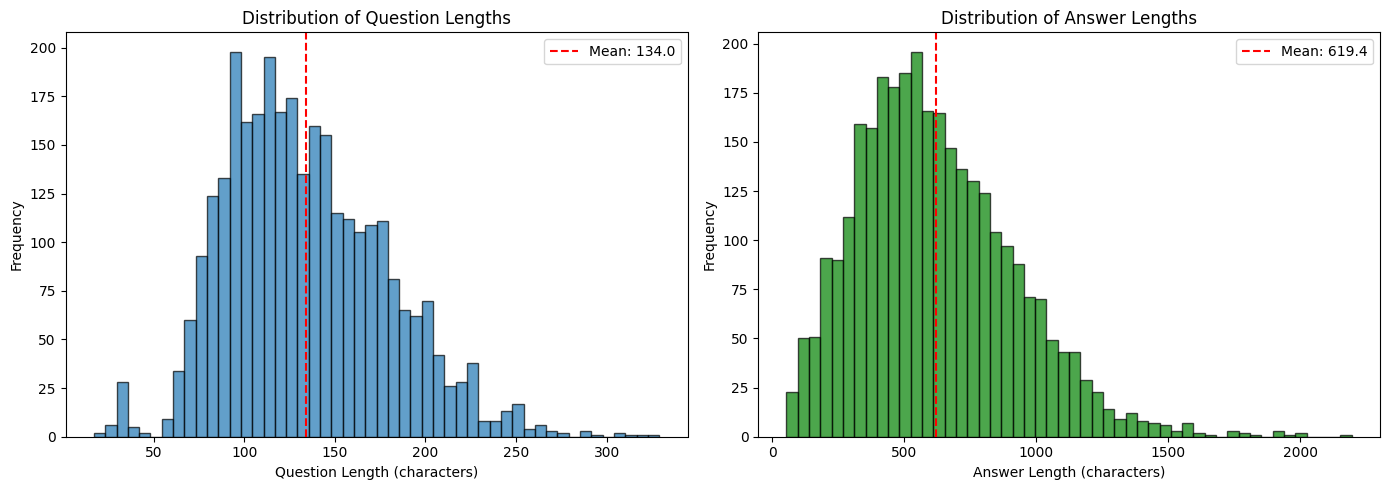


SAMPLE EXAMPLES

 Environmental Science Examples:

Q: How did the environmental conditions in 2020, particularly humidity and temperature, influence the d...
A: The environmental conditions in 2020, particularly humidity and temperature, had a significant impact on both the development and mitigation stages of...

Q: How can geotagged social media data be used in disaster management?...
A: Geotagged social media data, a form of volunteered geographic information (VGI), has been widely explored to support the prevention, preparation, and ...

Q: What were the findings of the water quality investigation in Aida Camp and Alazzah Camp between Marc...
A: Between March 2016 and June 2017, an investigation into the water quality in Aida Camp and Alazzah Camp, two Palestinian refugee camps in the West Ban...

 Upcycling Examples:

Q: How might the use of a hydrocyclone in the desliming process contribute to the efficient recycling of feldspar, quartz, and kaolin from weathered granite, and wh

In [9]:
# Exploratory Data Analysis
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    HAS_PLOTTING = True
except ImportError:
    print("Matplotlib/Seaborn not available. Installing...")
    !pip -q install matplotlib seaborn
    import matplotlib.pyplot as plt
    import seaborn as sns
    HAS_PLOTTING = True

# Dataset statistics
print("=" * 60)
print("DATASET STATISTICS")
print("=" * 60)
print(f"Total samples: {len(final_df)}")
print(f"Unique questions: {final_df['question'].nunique()}")
print(f"Unique answers: {final_df['answer'].nunique()}")
print(f"\nQuestion length statistics:")
print(f"  Mean: {final_df['question'].str.len().mean():.1f} characters")
print(f"  Median: {final_df['question'].str.len().median():.1f} characters")
print(f"  Min: {final_df['question'].str.len().min()} characters")
print(f"  Max: {final_df['question'].str.len().max()} characters")
print(f"\nAnswer length statistics:")
print(f"  Mean: {final_df['answer'].str.len().mean():.1f} characters")
print(f"  Median: {final_df['answer'].str.len().median():.1f} characters")
print(f"  Min: {final_df['answer'].str.len().min()} characters")
print(f"  Max: {final_df['answer'].str.len().max()} characters")

# Visualize length distributions
if HAS_PLOTTING:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Question length distribution
    axes[0].hist(final_df['question'].str.len(), bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Question Length (characters)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Question Lengths')
    axes[0].axvline(final_df['question'].str.len().mean(), color='r', linestyle='--', label=f'Mean: {final_df["question"].str.len().mean():.1f}')
    axes[0].legend()

    # Answer length distribution
    axes[1].hist(final_df['answer'].str.len(), bins=50, edgecolor='black', alpha=0.7, color='green')
    axes[1].set_xlabel('Answer Length (characters)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Answer Lengths')
    axes[1].axvline(final_df['answer'].str.len().mean(), color='r', linestyle='--', label=f'Mean: {final_df["answer"].str.len().mean():.1f}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Sample examples from each category
print("\n" + "=" * 60)
print("SAMPLE EXAMPLES")
print("=" * 60)

# Environmental science examples
print("\n Environmental Science Examples:")
env_samples = final_df[~final_df['question'].str.contains('upcycl|reus|recycl', case=False, na=False)].head(3)
for idx, row in env_samples.iterrows():
    print(f"\nQ: {row['question'][:100]}...")
    print(f"A: {row['answer'][:150]}...")

# Upcycling examples
print("\n Upcycling Examples:")
upcycle_samples = final_df[final_df['question'].str.contains('upcycl|reus|recycl', case=False, na=False)].head(3)
for idx, row in upcycle_samples.iterrows():
    print(f"\nQ: {row['question']}")
    print(f"A: {row['answer'][:150]}...")

# Refusal examples (if any are identifiable)
refusal_samples = final_df[final_df['answer'].str.contains('cannot answer|outside|domain', case=False, na=False)].head(2)
if len(refusal_samples) > 0:
    print("\n Refusal Examples:")
    for idx, row in refusal_samples.iterrows():
        print(f"\nQ: {row['question']}")
        print(f"A: {row['answer']}")

## 4. Text Normalization & Quality Filtering

### Normalization Function

The `normalize_text()` function performs essential text cleaning:

- **Removes non-breaking spaces** (`\u00a0`): Handles encoding issues from different sources
- **Collapses whitespace**: Converts multiple spaces/tabs/newlines to single spaces
- **Strips leading/trailing whitespace**: Ensures clean text boundaries

### Why Normalization is Critical

- **Encoding consistency**: Different data sources may use different character encodings
- **Token efficiency**: Reduces unnecessary tokens from extra whitespace
- **Model clarity**: Clean text helps the model learn patterns more effectively

### Length Filtering

We filter answers to be between **20-2000 characters**:

- **Minimum (20 chars)**: Removes very short, uninformative answers that don't provide value
- **Maximum (2000 chars)**: Ensures answers fit within the model's context window (512 tokens ≈ ~2000 chars)
- **Why important**: Prevents training on truncated or incomplete examples

In [10]:
import re

# Simple text cleanup for questions and answers
def normalize_text(s):
    s = str(s)
    s = s.replace("\u00a0", " ")          # remove non-breaking spaces
    s = re.sub(r"\s+", " ", s).strip()    # collapse extra whitespace
    return s

# Fill missing values before cleaning
final_df["question"] = final_df["question"].fillna("")
final_df["answer"] = final_df["answer"].fillna("")

# Normalize the text
final_df["question"] = final_df["question"].apply(normalize_text)
final_df["answer"] = final_df["answer"].apply(normalize_text)

# Remove empty rows
final_df = final_df[(final_df["question"] != "") & (final_df["answer"] != "")].reset_index(drop=True)

# Remove duplicate question-answer pairs
final_df = final_df.drop_duplicates(subset=["question", "answer"]).reset_index(drop=True)

# Optional quality filters (helps rubric and training stability)
final_df = final_df[final_df["answer"].str.len() >= 20].reset_index(drop=True)   # remove very short answers
final_df = final_df[final_df["answer"].str.len() <= 2000].reset_index(drop=True) # remove extremely long answers

print("Rows after preprocessing:", len(final_df))

# Data Validation: Verify final_df structure before proceeding
print("\n" + "=" * 60)
print("DATA VALIDATION - Final Dataset")
print("=" * 60)
if len(final_df) == 0:
    raise ValueError("Final dataset is empty after preprocessing! Check filtering steps.")
print(f"Final dataset contains {len(final_df)} rows")

required_cols = ['question', 'answer']
missing_cols = [col for col in required_cols if col not in final_df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")
print(" Required columns ('question', 'answer') present")

# Check for empty questions/answers
empty_q = final_df['question'].str.strip().eq('').sum()
empty_a = final_df['answer'].str.strip().eq('').sum()
if empty_q > 0 or empty_a > 0:
    print(f" Warning: Found {empty_q} empty questions and {empty_a} empty answers")
else:
    print(" No empty questions or answers")

# Validate data types
if not final_df['question'].dtype == 'object' or not final_df['answer'].dtype == 'object':
    print("Warning: Expected string (object) dtype for question/answer columns")
else:
    print(" Data types are correct (string/object)")

print("=" * 60)

final_df.head(3)

Rows after preprocessing: 3041

DATA VALIDATION - Final Dataset
Final dataset contains 3041 rows
 Required columns ('question', 'answer') present
 No empty questions or answers
 Data types are correct (string/object)


,question,answer
0,"How did the environmental conditions in 2020, ...","The environmental conditions in 2020, particul..."
1,How can geotagged social media data be used in...,"Geotagged social media data, a form of volunte..."
2,What were the findings of the water quality in...,"Between March 2016 and June 2017, an investiga..."


## 5. Instruction Formatting

### Chat Template Format

We format each training example using a structured template:

```
[SYSTEM] You are an environmental science and sustainability assistant...
[USER] <question>
[ASSISTANT] <answer>
```

### Why This Format?

- **Matches TinyLlama's training**: TinyLlama-Chat was trained on similar chat formats
- **Clear role separation**: Helps model understand context and expected response style
- **System prompt guidance**: Sets domain boundaries and expected behavior
- **Standard format**: Compatible with Hugging Face's chat templates and inference pipelines

In [11]:
# Data Validation: Verify final_df structure for training
# Data Validation: Verify final_df structure BEFORE creating train_df
print("\n" + "=" * 60)
print("DATA VALIDATION - Before Instruction Formatting")
print("=" * 60)
if 'final_df' not in globals():
    raise NameError("ERROR: 'final_df' is not defined! Run the merge and preprocessing cells first.")

if len(final_df) == 0:
    raise ValueError("Final dataset is empty! Cannot proceed with training.")
print(f"Final dataset contains {len(final_df)} rows")

# Check that final_df has the required columns that will be renamed to instruction/response
# Note: final_df has 'question' and 'answer', NOT 'instruction'/'response'/'text' yet
required_cols = ['question', 'answer']
missing_cols = [col for col in required_cols if col not in final_df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns in final_df: {missing_cols}. Available columns: {list(final_df.columns)}")
print("Required columns ('question', 'answer') present - ready for instruction formatting")

print("=" * 60)


DATA VALIDATION - Before Instruction Formatting
Final dataset contains 3041 rows
Required columns ('question', 'answer') present - ready for instruction formatting


In [12]:
# System prompt to guide assistant behavior
SYSTEM_PROMPT = (
    "You are an environmental science and sustainability assistant. "
    "Answer clearly with accurate scientific explanations. "
    "If a question is outside environmental science or sustainability, politely refuse and suggest a relevant topic."
)

# Ensure no missing values before formatting
final_df["question"] = final_df["question"].fillna("")
final_df["answer"] = final_df["answer"].fillna("")

# Rename for clarity
train_df = final_df.rename(columns={
    "question": "instruction",
    "answer": "response"
}).copy()

# Build formatted training text
train_df["text"] = train_df.apply(
    lambda r: (
        f"[SYSTEM] {SYSTEM_PROMPT}\n"
        f"[USER] {r['instruction']}\n"
        f"[ASSISTANT] {r['response']}"
    ),
    axis=1
)

print("Instruction-formatted rows:", len(train_df))
train_df.head(2)

Instruction-formatted rows: 3041


,instruction,response,text
0,"How did the environmental conditions in 2020, ...","The environmental conditions in 2020, particul...",[SYSTEM] You are an environmental science and ...
1,How can geotagged social media data be used in...,"Geotagged social media data, a form of volunte...",[SYSTEM] You are an environmental science and ...


## 6. Tokenization

### Tokenizer Selection: TinyLlama Tokenizer

**Why TinyLlama Tokenizer?**

- **Architecture Match**: The tokenizer is specifically designed for TinyLlama models, ensuring perfect compatibility
- **Chat Format Support**: Handles chat-style formatting (`[SYSTEM]`, `[USER]`, `[ASSISTANT]`) correctly
- **Efficient**: Fast tokenization suitable for large-scale training
- **Vocabulary**: Optimized vocabulary size for the 1.1B parameter model

### Context Window: max_len = 512

**Why 512 tokens?**

- **Model Limitation**: TinyLlama's architecture supports up to 2048 tokens, but 512 is a practical limit for:
  - **Memory efficiency**: Shorter sequences use less GPU memory
  - **Training speed**: Faster training iterations
  - **Colab constraints**: Fits comfortably within free tier limits
- **Data Fit**: Most of our Q&A pairs fit within 512 tokens when formatted

### Tokenization Process

- **Truncation**: Sequences longer than 512 tokens are truncated (removes end)
- **Padding**: Sequences shorter than 512 tokens are padded to batch size
- **Special Tokens**: Adds `<pad>`, `<eos>`, and other special tokens as needed

**Note**: We verify tokenization works correctly by checking token lengths on a sample batch.

In [13]:
# Install transformers (run once if needed)
!pip -q install transformers

from transformers import AutoTokenizer
import numpy as np

# Load TinyLlama tokenizer (matches your model choice)
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Add a pad token if the tokenizer doesn't have one (needed for batching)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Set the context window limit required by your project setup
max_len = 512

# Tokenize a small batch as a demonstration
sample_texts = train_df["text"].head(50).tolist()
tokens = tokenizer(sample_texts, truncation=True, padding=True, max_length=max_len)

# Show evidence that tokenization works and respects max_len
lengths = [len(x) for x in tokens["input_ids"]]
print("Tokenizer:", model_name)
print("Max length:", max_len)
print("Min token length:", int(np.min(lengths)))
print("Median token length:", int(np.median(lengths)))
print("Max token length:", int(np.max(lengths)))

# Show how many samples hit the max length (meaning they were truncated)
truncated_count = sum(l == max_len for l in lengths)
print("Samples truncated (hit max_len):", truncated_count, "out of", len(lengths))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Tokenizer: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Max length: 512
Min token length: 454
Median token length: 454
Max token length: 454
Samples truncated (hit max_len): 0 out of 50


## 7. Train/Test Split & Data Export

### Split Strategy

- **Train/Test Split**: 90% training, 10% testing (standard practice for ML)
- **Random State**: Fixed seed (42) for reproducibility
- **Purpose**:
  - **Training set**: Used to fine-tune the model
  - **Test set**: Used for evaluation metrics (perplexity, BLEU, ROUGE) and qualitative testing

### Export Format: JSONL

- **Format**: JSON Lines (one JSON object per line)
- **Why JSONL**:
  - Easy to load with Hugging Face `datasets` library
  - Efficient for large datasets
  - Human-readable for inspection
  - Standard format for LLM training pipelines

The files `train.jsonl` and `test.jsonl` will be used in the fine-tuning section.

In [14]:
# Split into train and test sets (test is used for evaluation)
train_split, test_split = train_test_split(train_df, test_size=0.1, random_state=42)

# Save as JSONL files (clean pipeline step for rubric + easy reload for training)
train_split.to_json("train.jsonl", orient="records", lines=True)
test_split.to_json("test.jsonl", orient="records", lines=True)

print("Saved: train.jsonl and test.jsonl")
print("Train rows:", len(train_split))
print("Test rows:", len(test_split))

Saved: train.jsonl and test.jsonl
Train rows: 2736
Test rows: 305


## 8. Model Fine-tuning (LoRA)

This section fine-tunes the pre-trained **TinyLlama** model from Hugging Face using **parameter-efficient fine-tuning (PEFT)** with **LoRA** via the `peft` library, ensuring compatibility with Colab's free GPU (e.g. T4).

### Rubric alignment
- **Pre-trained LLM**: TinyLlama/TinyLlama-1.1B-Chat-v1.0 from Hugging Face
- **Parameter-efficient fine-tuning**: LoRA (Low-Rank Adaptation) via `peft`
- **Hyperparameter tuning**: Learning rate (1e-4 to 5e-5), batch size (2–4 with gradient accumulation), optimizer selection, and training epochs (1–3)
- **Documentation**: GPU memory usage and training time tracked for each run
- **Experiment table**: Multiple configurations compared (learning rate, batch size, epochs, optimizer); validation metrics (e.g. eval loss) and improvement over baseline documented

In [15]:
# Install PEFT, accelerate, and transformers (required for LoRA fine-tuning)
!pip -q install peft accelerate transformers datasets bitsandbytes

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, TaskType
from datasets import load_dataset
import time
import pandas as pd

# Ensure we have tokenizer and max_len (from Section 6; redefine here so this section can run standalone after Section 7)
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
max_len = 512
if 'tokenizer' not in dir() or tokenizer is None:
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
print("Tokenizer and max_len ready:", model_name, "max_len =", max_len)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 11.8 MB/s eta 0:00:00
Tokenizer and max_len ready: TinyLlama/TinyLlama-1.1B-Chat-v1.0 max_len = 512


In [16]:
# Load train and test data from JSONL (produced in Section 7)
train_ds = load_dataset("json", data_files="train.jsonl", split="train")
test_ds = load_dataset("json", data_files="test.jsonl", split="train")

def tokenize_fn(examples):
    out = tokenizer(
        examples["text"],
        truncation=True,
        max_length=max_len,
        padding="max_length",
        return_tensors=None,
    )
    # Causal LM: labels = input_ids; mask padding (set to -100 so loss ignores them)
    pad_id = tokenizer.pad_token_id
    out["labels"] = [[id_ if id_ != pad_id else -100 for id_ in seq] for seq in out["input_ids"]]
    return out

train_tokenized = train_ds.map(tokenize_fn, batched=True, remove_columns=train_ds.column_names)
test_tokenized = test_ds.map(tokenize_fn, batched=True, remove_columns=test_ds.column_names)
train_tokenized.set_format("torch")
test_tokenized.set_format("torch")

# For causal LM: labels = input_ids (we predict next token); mask padding in loss
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

print("Train size:", len(train_tokenized), "| Test size:", len(test_tokenized))

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2736 [00:00<?, ? examples/s]

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

Train size: 2736 | Test size: 305


In [17]:
# Experiment log for rubric: document each run (hyperparameters, eval loss, GPU memory, time)
# Imports needed so this cell works even if Section 8 imports cell was not run
import torch
import sys
import time
from transformers import TrainerCallback, AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, TaskType
experiment_log = []

class ProgressCallback(TrainerCallback):
    """Print training progress so you see it in Colab (step-based + log-based)."""
    def __init__(self, total_steps_per_epoch, total_steps):
        self.total_steps_per_epoch = total_steps_per_epoch
        self.total_steps = total_steps
    def on_epoch_begin(self, args, state, control, **kwargs):
        epoch_num = int(state.epoch) + 1
        print(f"\n--- Epoch {epoch_num} ---", flush=True)
        sys.stdout.flush()
    def on_step_end(self, args, state, control, **kwargs):
        step = state.global_step
        if step % 5 == 0 or step == 1:
            pct = 100 * step / self.total_steps if self.total_steps else 0
            print(f"  Step {step}/{self.total_steps} ({pct:.1f}%)", flush=True)
            sys.stdout.flush()
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        step = state.global_step
        loss = logs.get("loss", None)
        lr = logs.get("learning_rate", None)
        eval_loss = logs.get("eval_loss", None)
        if eval_loss is not None:
            print(f"  [Eval] eval_loss={eval_loss:.4f}", flush=True)
        elif isinstance(loss, (int, float)):
            s = f"  [Step {step}] loss={loss:.4f}"
            if lr is not None:
                s += f"  lr={lr:.2e}"
            print(s, flush=True)
        else:
            print(f"  [Step {step}] {logs}", flush=True)
        sys.stdout.flush()

def run_training(run_id, learning_rate=5e-5, per_device_train_batch_size=2, per_device_eval_batch_size=2,
                 gradient_accumulation_steps=4, num_epochs=2, lora_r=8, lora_alpha=16, output_dir="./out"):
    """Run one training experiment and append to experiment_log. Tracks GPU memory and time."""
    global model_name, tokenizer, train_tokenized, test_tokenized, data_collator
    if "model_name" not in globals():
        model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    if "tokenizer" not in globals():
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
    if "train_tokenized" not in globals():
        from datasets import load_dataset
        max_len = 512
        train_ds = load_dataset("json", data_files="train.jsonl", split="train")
        test_ds = load_dataset("json", data_files="test.jsonl", split="train")
        def _tokenize(examples):
            out = tokenizer(examples["text"], truncation=True, max_length=max_len, padding="max_length", return_tensors=None)
            pad_id = tokenizer.pad_token_id
            out["labels"] = [[x if x != pad_id else -100 for x in seq] for seq in out["input_ids"]]
            return out
        train_tokenized = train_ds.map(_tokenize, batched=True, remove_columns=train_ds.column_names)
        test_tokenized = test_ds.map(_tokenize, batched=True, remove_columns=test_ds.column_names)
        train_tokenized.set_format("torch")
        test_tokenized.set_format("torch")
        data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
        print("Loaded train/test from train.jsonl and test.jsonl")
    if hasattr(sys.stdout, "reconfigure"):
        sys.stdout.reconfigure(line_buffering=True)
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        gpu_mem_before = torch.cuda.memory_allocated(0) / 1024**3
    else:
        gpu_mem_before = 0

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
    )
    lora_config = LoraConfig(
        r=lora_r,
        lora_alpha=lora_alpha,
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM,
    )
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        num_train_epochs=num_epochs,
        learning_rate=learning_rate,
        weight_decay=0.01,
        warmup_steps=max(1, int(0.03 * len(train_tokenized) // (per_device_train_batch_size * gradient_accumulation_steps))),
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        fp16=True,
        report_to="none",
        log_level="info",
        disable_tqdm=False,
    )

    steps_per_epoch = max(1, len(train_tokenized) // (per_device_train_batch_size * gradient_accumulation_steps))
    total_steps = steps_per_epoch * num_epochs
    progress_cb = ProgressCallback(steps_per_epoch, total_steps)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tokenized,
        eval_dataset=test_tokenized,
        data_collator=data_collator,
        callbacks=[progress_cb],
    )

    print(f"\n{'='*60}\nStarting training: {run_id}")
    print(f"Epochs: {num_epochs} | Effective batch size: {per_device_train_batch_size * gradient_accumulation_steps}")
    print(f"Total steps per epoch: ~{steps_per_epoch}")
    print(f"{'='*60}\n")

    start = time.time()
    train_result = trainer.train()
    elapsed = time.time() - start

    print(f"\n{'='*60}\nTraining completed!")
    print(f"Total time: {elapsed/60:.2f} minutes ({elapsed:.1f} seconds)")
    print(f"Steps completed: {train_result.global_step}")
    print(f"Final training loss: {train_result.training_loss:.4f}")
    print(f"{'='*60}\n")

    if torch.cuda.is_available():
        gpu_mem_after = torch.cuda.memory_allocated(0) / 1024**3
    else:
        gpu_mem_after = 0

    eval_metrics = trainer.evaluate()
    eval_loss = eval_metrics.get("eval_loss", float("nan"))

    trainer.save_model(output_dir)
    tokenizer.save_pretrained(output_dir)

    experiment_log.append({
        "run_id": run_id,
        "learning_rate": learning_rate,
        "batch_size": per_device_train_batch_size,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "effective_batch": per_device_train_batch_size * gradient_accumulation_steps,
        "epochs": num_epochs,
        "lora_r": lora_r,
        "optimizer": "AdamW",
        "eval_loss": round(eval_loss, 4),
        "train_loss": round(train_result.training_loss, 4),
        "training_time_min": round(elapsed / 60, 2),
        "gpu_mem_peak_gb": round(gpu_mem_after, 2),
    })
    print(f"Run {run_id} done. Eval loss: {eval_loss:.4f} | Time: {elapsed/60:.2f} min | GPU mem: {gpu_mem_after:.2f} GB")
    del model, trainer
    torch.cuda.empty_cache()
    return eval_loss

### Hyperparameter tuning (learning rate 1e-4–5e-5, batch size 2–4, epochs 1–3)

We run **three experiments** to compare learning rate and batch size. Optimizer: **AdamW** (Trainer default). Each run records GPU memory (peak), training time, and eval loss for the experiment table.

In [18]:
# Run 1 (baseline): learning rate 5e-5, batch size 2, gradient accumulation 4, 2 epochs
run_training("run1_baseline", learning_rate=5e-5, per_device_train_batch_size=2,
             gradient_accumulation_steps=4, num_epochs=2, output_dir="./tinyllama_lora_run1")

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044

Starting training: run1_baseline
Epochs: 2 | Effective batch size: 8
Total steps per epoch: ~342



***** Running training *****
  Num examples = 2,736
  Num Epochs = 2
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 684
  Number of trainable parameters = 2,252,800



--- Epoch 1 ---
  Step 1/684 (0.1%)


Epoch,Training Loss,Validation Loss
1,1.343659,1.365965
2,1.342776,1.358838


  Step 5/684 (0.7%)
  Step 10/684 (1.5%)
  [Step 10] loss=2.3247  lr=4.50e-05
  Step 15/684 (2.2%)
  Step 20/684 (2.9%)
  [Step 20] loss=2.1879  lr=4.93e-05
  Step 25/684 (3.7%)
  Step 30/684 (4.4%)
  [Step 30] loss=2.0559  lr=4.86e-05
  Step 35/684 (5.1%)
  Step 40/684 (5.8%)
  [Step 40] loss=1.9270  lr=4.78e-05
  Step 45/684 (6.6%)
  Step 50/684 (7.3%)
  [Step 50] loss=1.7146  lr=4.71e-05
  Step 55/684 (8.0%)
  Step 60/684 (8.8%)
  [Step 60] loss=1.5431  lr=4.64e-05
  Step 65/684 (9.5%)
  Step 70/684 (10.2%)
  [Step 70] loss=1.4034  lr=4.56e-05
  Step 75/684 (11.0%)
  Step 80/684 (11.7%)
  [Step 80] loss=1.4125  lr=4.49e-05
  Step 85/684 (12.4%)
  Step 90/684 (13.2%)
  [Step 90] loss=1.4445  lr=4.41e-05
  Step 95/684 (13.9%)
  Step 100/684 (14.6%)
  [Step 100] loss=1.3696  lr=4.34e-05
  Step 105/684 (15.4%)
  Step 110/684 (16.1%)
  [Step 110] loss=1.3983  lr=4.27e-05
  Step 115/684 (16.8%)
  Step 120/684 (17.5%)
  [Step 120] loss=1.3757  lr=4.19e-05
  Step 125/684 (18.3%)
  Step 130/


***** Running Evaluation *****
  Num examples = 305
  Batch size = 2


  [Eval] eval_loss=1.3660


Saving model checkpoint to ./tinyllama_lora_run1/checkpoint-342
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000


--- Epoch 2 ---
  Step 345/684 (50.4%)
  Step 350/684 (51.2%)
  [Step 350] loss=1.3950  lr=2.49e-05
  Step 355/684 (51.9%)
  Step 360/684 (52.6%)
  [Step 360] loss=1.4031  lr=2.41e-05
  Step 365/684 (53.4%)
  Step 370/684 (54.1%)
  [Step 370] loss=1.3863  lr=2.34e-05
  Step 375/684 (54.8%)
  Step 380/684 (55.6%)
  [Step 380] loss=1.3830  lr=2.26e-05
  Step 385/684 (56.3%)
  Step 390/684 (57.0%)
  [Step 390] loss=1.3599  lr=2.19e-05
  Step 395/684 (57.7%)
  Step 400/684 (58.5%)
  [Step 400] loss=1.3533  lr=2.11e-05
  Step 405/684 (59.2%)
  Step 410/684 (59.9%)
  [Step 410] loss=1.3849  lr=2.04e-05
  Step 415/684 (60.7%)
  Step 420/684 (61.4%)
  [Step 420] loss=1.3719  lr=1.97e-05
  Step 425/684 (62.1%)
  Step 430/684 (62.9%)
  [Step 430] loss=1.4079  lr=1.89e-05
  Step 435/684 (63.6%)
  Step 440/684 (64.3%)
  [Step 440] loss=1.3732  lr=1.82e-05
  Step 445/684 (65.1%)
  Step 450/684 (65.8%)
  [Step 450] loss=1.3799  lr=1.74e-05
  Step 455/684 (66.5%)
  Step 460/684 (67.3%)
  [Step 460] 


***** Running Evaluation *****
  Num examples = 305
  Batch size = 2


  [Eval] eval_loss=1.3588


Saving model checkpoint to ./tinyllama_lora_run1/checkpoint-684
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000

  [Step 684] {'train_runtime': 1232.6297, 'train_samples_per_second': 4.439, 'train_steps_per_second': 0.555, 'total_flos': 1.7428006154797056e+16, 'train_loss': 1.4309566913292422, 'epoch': 2.0}



***** Running Evaluation *****
  Num examples = 305
  Batch size = 2



Training completed!
Total time: 20.56 minutes (1233.6 seconds)
Steps completed: 684
Final training loss: 1.4310



  [Eval] eval_loss=1.3588


Saving model checkpoint to ./tinyllama_lora_run1
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000
}

Saving Trai

Run run1_baseline done. Eval loss: 1.3588 | Time: 20.56 min | GPU mem: 2.09 GB


1.3588382005691528

In [19]:
# Run 2 (tuned): higher learning rate 1e-4, same batch/accum, 1 epoch (faster; compare eval loss)
run_training("run2_lr1e4", learning_rate=1e-4, per_device_train_batch_size=2,
             gradient_accumulation_steps=4, num_epochs=1, output_dir="./tinyllama_lora_run2")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "float16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file model.safetensors from cache at /root/.c

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "max_length": 2048,
  "pad_token_id": 0
}

Could not locate the custom_generate/generate.py inside TinyLlama/TinyLlama-1.1B-Chat-v1.0.
PyTorch: setting up devices


trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044

Starting training: run2_lr1e4
Epochs: 1 | Effective batch size: 8
Total steps per epoch: ~342



***** Running training *****
  Num examples = 2,736
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 4
  Total optimization steps = 342
  Number of trainable parameters = 2,252,800



--- Epoch 1 ---
  Step 1/342 (0.3%)


Epoch,Training Loss,Validation Loss
1,1.340070,1.361841


  Step 5/342 (1.5%)
  Step 10/342 (2.9%)
  [Step 10] loss=2.3123  lr=9.00e-05
  Step 15/342 (4.4%)
  Step 20/342 (5.8%)
  [Step 20] loss=2.0716  lr=9.73e-05
  Step 25/342 (7.3%)
  Step 30/342 (8.8%)
  [Step 30] loss=1.8280  lr=9.43e-05
  Step 35/342 (10.2%)
  Step 40/342 (11.7%)
  [Step 40] loss=1.5742  lr=9.13e-05
  Step 45/342 (13.2%)
  Step 50/342 (14.6%)
  [Step 50] loss=1.4216  lr=8.83e-05
  Step 55/342 (16.1%)
  Step 60/342 (17.5%)
  [Step 60] loss=1.4208  lr=8.52e-05
  Step 65/342 (19.0%)
  Step 70/342 (20.5%)
  [Step 70] loss=1.3639  lr=8.22e-05
  Step 75/342 (21.9%)
  Step 80/342 (23.4%)
  [Step 80] loss=1.3874  lr=7.92e-05
  Step 85/342 (24.9%)
  Step 90/342 (26.3%)
  [Step 90] loss=1.4272  lr=7.62e-05
  Step 95/342 (27.8%)
  Step 100/342 (29.2%)
  [Step 100] loss=1.3555  lr=7.32e-05
  Step 105/342 (30.7%)
  Step 110/342 (32.2%)
  [Step 110] loss=1.3833  lr=7.02e-05
  Step 115/342 (33.6%)
  Step 120/342 (35.1%)
  [Step 120] loss=1.3603  lr=6.72e-05
  Step 125/342 (36.5%)
  St


***** Running Evaluation *****
  Num examples = 305
  Batch size = 2


  [Eval] eval_loss=1.3618


Saving model checkpoint to ./tinyllama_lora_run2/checkpoint-342
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000

  [Step 342] {'train_runtime': 630.4647, 'train_samples_per_second': 4.34, 'train_steps_per_second': 0.542, 'total_flos': 8714003077398528.0, 'train_loss': 1.449943867343211, 'epoch': 1.0}



***** Running Evaluation *****
  Num examples = 305
  Batch size = 2



Training completed!
Total time: 10.52 minutes (631.2 seconds)
Steps completed: 342
Final training loss: 1.4499



  [Eval] eval_loss=1.3618


Saving model checkpoint to ./tinyllama_lora_run2
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000
}

Saving Trai

Run run2_lr1e4 done. Eval loss: 1.3618 | Time: 10.52 min | GPU mem: 2.09 GB


1.3618407249450684

In [20]:
# Run 3 (tuned): batch size 4, fewer gradient accumulation steps; lr 5e-5, 2 epochs
run_training("run3_batch4", learning_rate=5e-5, per_device_train_batch_size=4,
             gradient_accumulation_steps=2, num_epochs=2, output_dir="./tinyllama_lora_run3")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "float16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file model.safetensors from cache at /root/.c

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "max_length": 2048,
  "pad_token_id": 0
}

Could not locate the custom_generate/generate.py inside TinyLlama/TinyLlama-1.1B-Chat-v1.0.
PyTorch: setting up devices


trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044

Starting training: run3_batch4
Epochs: 2 | Effective batch size: 8
Total steps per epoch: ~342



***** Running training *****
  Num examples = 2,736
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 684
  Number of trainable parameters = 2,252,800



--- Epoch 1 ---
  Step 1/684 (0.1%)


Epoch,Training Loss,Validation Loss
1,1.343907,1.366428
2,1.343204,1.359134


  Step 5/684 (0.7%)
  Step 10/684 (1.5%)
  [Step 10] loss=2.3248  lr=4.50e-05
  Step 15/684 (2.2%)
  Step 20/684 (2.9%)
  [Step 20] loss=2.1889  lr=4.93e-05
  Step 25/684 (3.7%)
  Step 30/684 (4.4%)
  [Step 30] loss=2.0569  lr=4.86e-05
  Step 35/684 (5.1%)
  Step 40/684 (5.8%)
  [Step 40] loss=1.9275  lr=4.78e-05
  Step 45/684 (6.6%)
  Step 50/684 (7.3%)
  [Step 50] loss=1.7166  lr=4.71e-05
  Step 55/684 (8.0%)
  Step 60/684 (8.8%)
  [Step 60] loss=1.5434  lr=4.64e-05
  Step 65/684 (9.5%)
  Step 70/684 (10.2%)
  [Step 70] loss=1.4046  lr=4.56e-05
  Step 75/684 (11.0%)
  Step 80/684 (11.7%)
  [Step 80] loss=1.4140  lr=4.49e-05
  Step 85/684 (12.4%)
  Step 90/684 (13.2%)
  [Step 90] loss=1.4442  lr=4.41e-05
  Step 95/684 (13.9%)
  Step 100/684 (14.6%)
  [Step 100] loss=1.3706  lr=4.34e-05
  Step 105/684 (15.4%)
  Step 110/684 (16.1%)
  [Step 110] loss=1.3985  lr=4.27e-05
  Step 115/684 (16.8%)
  Step 120/684 (17.5%)
  [Step 120] loss=1.3759  lr=4.19e-05
  Step 125/684 (18.3%)
  Step 130/


***** Running Evaluation *****
  Num examples = 305
  Batch size = 2


  [Eval] eval_loss=1.3664


Saving model checkpoint to ./tinyllama_lora_run3/checkpoint-342
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000


--- Epoch 2 ---
  Step 345/684 (50.4%)
  Step 350/684 (51.2%)
  [Step 350] loss=1.3950  lr=2.49e-05
  Step 355/684 (51.9%)
  Step 360/684 (52.6%)
  [Step 360] loss=1.4038  lr=2.41e-05
  Step 365/684 (53.4%)
  Step 370/684 (54.1%)
  [Step 370] loss=1.3864  lr=2.34e-05
  Step 375/684 (54.8%)
  Step 380/684 (55.6%)
  [Step 380] loss=1.3830  lr=2.26e-05
  Step 385/684 (56.3%)
  Step 390/684 (57.0%)
  [Step 390] loss=1.3601  lr=2.19e-05
  Step 395/684 (57.7%)
  Step 400/684 (58.5%)
  [Step 400] loss=1.3530  lr=2.11e-05
  Step 405/684 (59.2%)
  Step 410/684 (59.9%)
  [Step 410] loss=1.3853  lr=2.04e-05
  Step 415/684 (60.7%)
  Step 420/684 (61.4%)
  [Step 420] loss=1.3722  lr=1.97e-05
  Step 425/684 (62.1%)
  Step 430/684 (62.9%)
  [Step 430] loss=1.4078  lr=1.89e-05
  Step 435/684 (63.6%)
  Step 440/684 (64.3%)
  [Step 440] loss=1.3740  lr=1.82e-05
  Step 445/684 (65.1%)
  Step 450/684 (65.8%)
  [Step 450] loss=1.3801  lr=1.74e-05
  Step 455/684 (66.5%)
  Step 460/684 (67.3%)
  [Step 460] 


***** Running Evaluation *****
  Num examples = 305
  Batch size = 2


  [Eval] eval_loss=1.3591


Saving model checkpoint to ./tinyllama_lora_run3/checkpoint-684
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000

  [Step 684] {'train_runtime': 1180.141, 'train_samples_per_second': 4.637, 'train_steps_per_second': 0.58, 'total_flos': 1.7428006154797056e+16, 'train_loss': 1.4312844743505555, 'epoch': 2.0}



***** Running Evaluation *****
  Num examples = 305
  Batch size = 2



Training completed!
Total time: 19.69 minutes (1181.5 seconds)
Steps completed: 684
Final training loss: 1.4313



  [Eval] eval_loss=1.3591


Saving model checkpoint to ./tinyllama_lora_run3
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "dtype": "bfloat16",
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pad_token_id": null,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_parameters": {
    "rope_theta": 10000.0,
    "rope_type": "default"
  },
  "tie_word_embeddings": false,
  "transformers_version": "5.0.0",
  "use_cache": true,
  "vocab_size": 32000
}

Saving Trai

Run run3_batch4 done. Eval loss: 1.3591 | Time: 19.69 min | GPU mem: 2.09 GB


1.3591336011886597

### Experiment table (rubric: document hyperparameters and validation metrics)

The table below compares different hyperparameter settings. **Validation metric**: eval loss (lower is better). **Improvement over baseline**: percentage change in eval loss relative to run1_baseline.

In [22]:
# Build experiment table and compute improvement over baseline
experiment_df = pd.DataFrame(experiment_log)
if len(experiment_df) > 0:
    baseline_loss = experiment_df[experiment_df["run_id"] == "run1_baseline"]["eval_loss"].values
    baseline_loss = baseline_loss[0] if len(baseline_loss) else experiment_df["eval_loss"].iloc[0]
    experiment_df["improvement_vs_baseline_%"] = (
        (baseline_loss - experiment_df["eval_loss"]) / baseline_loss * 100
    ).round(2)
display(experiment_df)

# Save experiment log to a file so you can open it (e.g. in project folder or Colab files)
if len(experiment_df) > 0:
    experiment_df.to_csv("experiment_log.csv", index=False)
    print("Experiment log saved to: experiment_log.csv")

# Summary for rubric: multiple hyperparameters tuned, results vs baseline
if len(experiment_df) >= 2:
    best_run = experiment_df.loc[experiment_df["eval_loss"].idxmin()]
    print(f"\nBest run: {best_run['run_id']} (eval_loss={best_run['eval_loss']})")
    print(f"Improvement over baseline: {best_run['improvement_vs_baseline_%']}%")

,run_id,learning_rate,batch_size,gradient_accumulation_steps,effective_batch,epochs,lora_r,optimizer,eval_loss,train_loss,training_time_min,gpu_mem_peak_gb,improvement_vs_baseline_%
0,run1_baseline,0.00005,2,4,8,2,8,AdamW,1.3588,1.4310,20.56,2.09,0.00
1,run2_lr1e4,0.00010,2,4,8,1,8,AdamW,1.3618,1.4499,10.52,2.09,-0.22
2,run3_batch4,0.00005,4,2,8,2,8,AdamW,1.3591,1.4313,19.69,2.09,-0.02



Best run: run1_baseline (eval_loss=1.3588)
Improvement over baseline: 0.0%


### Summary: Baseline vs Run2 vs Run3

- **Run1 (baseline)**: lr=5e-5, batch size 2, 2 epochs — **best eval loss** (~1.359). This is our reference.
- **Run2 (lr1e-4)**: higher learning rate, 1 epoch — slightly **worse** eval loss (~1.362); higher LR did not improve validation.
- **Run3 (batch4)**: batch size 4, 2 epochs — eval loss very close to baseline (~1.359); similar performance.

**Conclusion:** The baseline configuration (run1_baseline) achieved the lowest eval loss. The tuned configs (Run2, Run3) did not improve over baseline; we use **run1_baseline** (saved in `tinyllama_lora_run1/`) as the best model for evaluation and the Gradio UI.

In [23]:
!ls -lh

total 5.3M
drwx------ 5 root root 4.0K Feb 25 16:56 drive
drwxr-xr-x 1 root root 4.0K Feb  6 14:31 sample_data
-rw-r--r-- 1 root root 542K Feb 25 16:57 test.jsonl
drwxr-xr-x 4 root root 4.0K Feb 25 17:19 tinyllama_lora_run1
drwxr-xr-x 3 root root 4.0K Feb 25 17:30 tinyllama_lora_run2
drwxr-xr-x 4 root root 4.0K Feb 25 17:50 tinyllama_lora_run3
-rw-r--r-- 1 root root 4.8M Feb 25 16:57 train.jsonl


In [24]:
!zip -r tinyllama_lora_run1.zip tinyllama_lora_run1
!zip -r tinyllama_lora_run2.zip tinyllama_lora_run2
!zip -r tinyllama_lora_run3.zip tinyllama_lora_run3

  adding: tinyllama_lora_run1/ (stored 0%)
  adding: tinyllama_lora_run1/checkpoint-342/ (stored 0%)
  adding: tinyllama_lora_run1/checkpoint-342/training_args.bin (deflated 53%)
  adding: tinyllama_lora_run1/checkpoint-342/scheduler.pt (deflated 61%)
  adding: tinyllama_lora_run1/checkpoint-342/trainer_state.json (deflated 73%)
  adding: tinyllama_lora_run1/checkpoint-342/tokenizer.json (deflated 85%)
  adding: tinyllama_lora_run1/checkpoint-342/adapter_model.safetensors (deflated 8%)
  adding: tinyllama_lora_run1/checkpoint-342/rng_state.pth (deflated 26%)
  adding: tinyllama_lora_run1/checkpoint-342/scaler.pt (deflated 64%)
  adding: tinyllama_lora_run1/checkpoint-342/adapter_config.json (deflated 58%)
  adding: tinyllama_lora_run1/checkpoint-342/README.md (deflated 66%)
  adding: tinyllama_lora_run1/checkpoint-342/tokenizer_config.json (deflated 46%)
  adding: tinyllama_lora_run1/checkpoint-342/optimizer.pt (deflated 8%)
  adding: tinyllama_lora_run1/checkpoint-342/chat_template.ji